In [1]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from keras.optimizers import Adam, SGD

# Keras imports
from keras.models import  Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

import glob

from loader_bot import LoaderBot
from splitter import get_skfold_data

import pandas as pd
import numpy as np
import argparse
import cv2

import matplotlib
matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# https://github.com/DeepLearningSandbox/DeepLearningSandbox/blob/master/transfer_learning/fine-tune.py

IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_EPOCHS = 3
BAT_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172

In [3]:
def setup_to_transfer_learn(model, base_model, lr=0.0001):
    """Freeze all layers and compile the model"""
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=SGD(lr=lr, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    

def add_brian_layers(base_model, num_classes, dropout=0.2):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x) #new FC layer, random init
    x = Dropout(dropout)(x)
    
    x = Dense(512, activation='relu', kernel_initializer='he_normal')(x) #new FC layer, random init
    x = Dropout(dropout)(x)
    
    x = Dense(256, activation='relu', kernel_initializer='he_normal')(x) #new FC layer, random init
    x = Dropout(dropout)(x)    
    
    predictions = Dense(num_classes, activation='softmax')(x) #new softmax layer
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model
    
    
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

def setup_to_finetune(model):
    """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.
    note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch
    Args:
    model: keras model
    """
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
        layer.trainable = False
        
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True
        
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    

def get_nb_files():
    file_paths = glob.glob("../data/stage1_imgs/*.jpg")
    
    return file_paths

def y_labels(file_paths):
    train_img_files = get_nb_files()

    y = np.zeros(len(nb_train_files), dtype=np.int16) # lol int8 overflowed at 128th label resulting in -128

    for idx, file in enumerate(train_img_files):
        # ex file: '../data/stage1_imgs/5766_86.jpg'
        y[idx] = int(file.split("/")[-1].split(".")[0].split("_")[-1])
        
    return y, train_img_files

def give_labels_get_dummies(y):
    '''
    y comes in as a list of ints from 1 to 128
    
    returns one hot matrix of the y values
    '''
    return pd.get_dummies(y.loc[:, "y"])

In [4]:
data_link_dict = get_skfold_data()

# Parameters for Generators
params = {'dim': (299,299),
          'batch_size': 256,
          'n_classes': 128,
          'n_channels': 3,
          'shuffle': False}

# Datasets
X_train_img_paths = data_link_dict["X_train_3"]
y_train = data_link_dict["y_train_3"]

X_test_img_paths = data_link_dict["X_test_3"]
y_test = data_link_dict["y_test_3"]




In [5]:
# Generators
training_generator = LoaderBot(X_train_img_paths, y_train, **params)
validation_generator = LoaderBot(X_test_img_paths, y_test, **params)


In [6]:
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
model = add_brian_layers(base_model, 128, 0.35)

# transfer learning
setup_to_transfer_learn(model, base_model, lr=0.0125)

history_tl = model.fit_generator(generator=training_generator,
                                 validation_data=validation_generator,
                                 epochs=20,
                                 use_multiprocessing=True,
                                 workers=6)

Epoch 1/20
726/726 [==============================] - 850s 1s/step - loss: 2.9883 - acc: 0.2861 - val_loss: 1.6744 - val_acc: 0.5195
Epoch 2/20
726/726 [==============================] - 807s 1s/step - loss: 1.8049 - acc: 0.5008 - val_loss: 1.5161 - val_acc: 0.5664
Epoch 3/20
726/726 [==============================] - 812s 1s/step - loss: 1.5672 - acc: 0.5619 - val_loss: 1.4297 - val_acc: 0.5903
Epoch 4/20
726/726 [==============================] - 810s 1s/step - loss: 1.4340 - acc: 0.5951 - val_loss: 1.3527 - val_acc: 0.6107
Epoch 5/20
726/726 [==============================] - 808s 1s/step - loss: 1.3389 - acc: 0.6190 - val_loss: 1.3045 - val_acc: 0.6250
Epoch 6/20
726/726 [==============================] - 808s 1s/step - loss: 1.2685 - acc: 0.6378 - val_loss: 1.2892 - val_acc: 0.6275
Epoch 7/20
726/726 [==============================] - 808s 1s/step - loss: 1.2067 - acc: 0.6536 - val_loss: 1.2405 - val_acc: 0.6408
Epoch 8/20
726/726 [==============================] - 808s 1s/step - 

Process ForkPoolWorker-218:
Process ForkPoolWorker-228:
Process ForkPoolWorker-222:
Process ForkPoolWorker-226:
Process ForkPoolWorker-220:
Process ForkPoolWorker-227:
Process ForkPoolWorker-224:
Process ForkPoolWorker-221:
Process ForkPoolWorker-225:
Process ForkPoolWorker-219:
Process ForkPoolWorker-223:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/brian/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/brian/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/brian/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, 

KeyboardInterrupt: 

In [11]:
# train/test split 2:  0.6636 acc at epoch 16, train acc 0.7347
# train/test split 2:  0.6672 acc at epoch 15, train acc 0.7280

TypeError: 'History' object is not iterable

In [7]:
def plot_hist(hist, epochs=2):
    '''
    Make a plot of the rate of error as well as the accuracy of the model
    during training.  Also include a line at error 0.20 which was the original
    minimum acceptable error (self imposed) to submit results to the test
    set when doing 3-way split.
    Even after performance regularly exceeded the minimum requirement the line
    was unchanged so that all of the graphs would be relative to each other.
    Also it was still useful to see how a model's error was performing relative
    to this baseline.
    Also, the 2 charts written as a png had the filename coded to include
    hyperparameters that were used in the model when the chart was created.
    This allowed a simple visual evaluation of a model's performance when
    doing randomized hyperparameter search. If a model appeared to be high
    performing then the values could be reused in order to attempt to
    replicate the result.
    '''
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

#     # this will become the filename with hyperparameter information
#     info_str = "m2_c1_epochs_{:03d}_lr_{:0.5f}_lrdecay_\
#             {:0.8f}_batch_{:03d}_dropout_{:0.5f}.png".format(self.epochs,
#                                                              self.learning_rate,
#                                                              self.lr_decay,
#                                                              self.batch_size,
#                                                              self.drop_out)
#     info_str = info_str.replace("1e-", "")

    fig.suptitle("", fontsize=12, fontweight='normal')

    # stuff for marking the major and minor ticks dynamically relative
    # to the numper of epochs used to train
    major_ticks = int(10 / 10.0)
    minor_ticks = int(10 / 20.0)

    if major_ticks < 2:
        major_ticks = 2

    if minor_ticks < 1:
        minor_ticks = 1

    majorLocator = MultipleLocator(major_ticks)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(minor_ticks)

    # correct x axis
    hist.history['loss'] = [0.0] + hist.history['loss']
    hist.history['val_loss'] = [0.0] + hist.history['val_loss']
    hist.history['acc'] = [0.0] + hist.history['acc']
    hist.history['val_acc'] = [0.0] + hist.history['val_acc']

    x_line = [0.2] * (epochs + 1)

    # stuff for the loss chart
    axs[0].set_title("Iceberg/Ship Classifier Loss Function Error\n Train Set and Dev Set")
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(1, epochs)
    axs[0].set_ylabel('Loss')
#     axs[0].set_ylim(0, 15)
    axs[0].plot(x_line, color="red", alpha=0.3, lw=4.0)
    axs[0].plot(hist.history['loss'], color="blue", linestyle="--", alpha=0.8, lw=1.0)
    axs[0].plot(hist.history['val_loss'], color="blue", alpha=0.8, lw=1.0)
    axs[0].plot(x_line, color="red", linestyle="--", alpha=0.8, lw=1.0)
    axs[0].legend(["Minimum Acceptable Error", 'Training', 'Validation'])
    axs[0].xaxis.set_major_locator(majorLocator)
    axs[0].xaxis.set_major_formatter(majorFormatter)

    # for the minor ticks, use no labels; default NullFormatter
    axs[0].xaxis.set_minor_locator(minorLocator)

    # stuff for the accuracy chart
    axs[1].set_title("Iceberg/Ship Classifier Accuracy\n Train Set and Dev Set")
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(1, epochs)
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0.0, 1.0)
    axs[1].plot(hist.history['acc'], color="blue", linestyle="--", alpha=0.5, lw=1.0)
    axs[1].plot(hist.history['val_acc'], color="blue", alpha=0.8, lw=1.0)
    axs[1].legend(['Training', 'Validation'], loc='lower right')
    axs[1].xaxis.set_major_locator(majorLocator)
    axs[1].xaxis.set_major_formatter(majorFormatter)

    # for the minor ticks, use no labels; default NullFormatter
    axs[1].xaxis.set_minor_locator(minorLocator)

#     plt.savefig("../imgs/" + info_str, facecolor='w', edgecolor='w', transparent=False)
    plt.show()

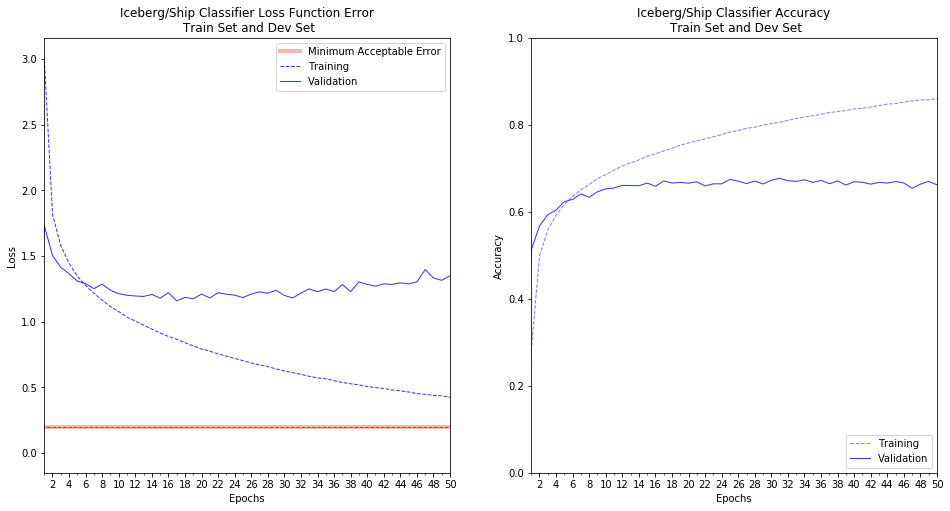

In [8]:
plot_hist(history_tl, epochs=50)